In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import sys
sys.path.append("..")

from PDMM import preprocessing as prep
from PDMM import  machine_learning as ml
from PDMM import visualization as viz
from PDMM.pipeline import AnomalyDetectionPipeline, sequential_training_pipeline, load_model

import config

In [2]:
# Select model
DATASET = 'TOTF'
MODEL = 'prae'
SCALER = 'box-cox'

config_path = f"models/{DATASET}_{SCALER}_{MODEL}_config.json"
weights_path = f"models/{DATASET}_{SCALER}_{MODEL}_weights.pth"
scaler_path = f"models/{DATASET}_{SCALER}_{MODEL}_scaler.pkl"
conf = config.DATASETS[DATASET]

In [3]:
# Initialize pipeline
setup_pipeline = AnomalyDetectionPipeline()

# Load data
if DATASET == 'TOTF': setup_pipeline.load_data(conf['path'])
elif DATASET == 'LOBSTER': setup_pipeline.raw_df = prep.load_lobster_data(conf['orderbook'], conf['message'])

# Engineer features
setup_pipeline.engineer_features(feature_sets=['base', 'tao', 'hawkes', 'poutre', 'ofi'])

# Scale and sequence data
setup_pipeline.scale_and_sequence(method='box-cox', train_ratio=0.7)

# Match training logic for test set
test_start_idx = int(len(setup_pipeline.processed_df) * 0.85)
test_df = setup_pipeline.processed_df.iloc[test_start_idx:].reset_index(drop=True)

Pipeline initialized on device: cuda
Loading data from data/TOTF.PA-book/2015-01-02-TOTF.PA-book.csv.gz...
Successfully loaded 640429 rows.
Engineering features: ['base', 'tao', 'hawkes', 'poutre', 'ofi']...
Feature Engineering complete. Total features: 130
Preprocessing with method: box-cox...
Dropping 2 constant/zero-variance features: ['ask_sweep_cost', 'ask-volume-10']
Data split: Train 448300, Val 96064, Test 96065


In [4]:
# Load model
pipeline, cfg = load_model(config_path, test_df, setup_pipeline.feature_names)

state_dict = torch.load(weights_path, map_location=pipeline.device)

Pipeline initialized on device: cuda


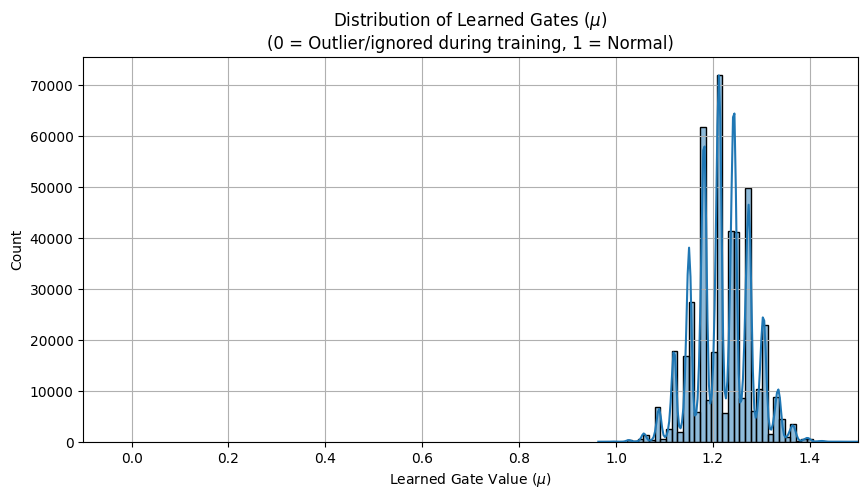

In [5]:
# Analysis
# For PRAE: Learned Gates
if 'mu' in state_dict:
    mu = state_dict['mu'].cpu().numpy()
    
    plt.figure(figsize=(10, 5))
    sns.histplot(mu, bins=50, kde=True)
    plt.title("Distribution of Learned Gates ($\mu$)\n(0 = Outlier/ignored during training, 1 = Normal)")
    plt.xlabel("Learned Gate Value ($\mu$)")
    plt.ylabel("Count")
    plt.xlim(-0.1, 1.5)
    plt.grid(True)
    plt.show()
else:
    print("Parameter 'mu' not found in the model state dictionary.")

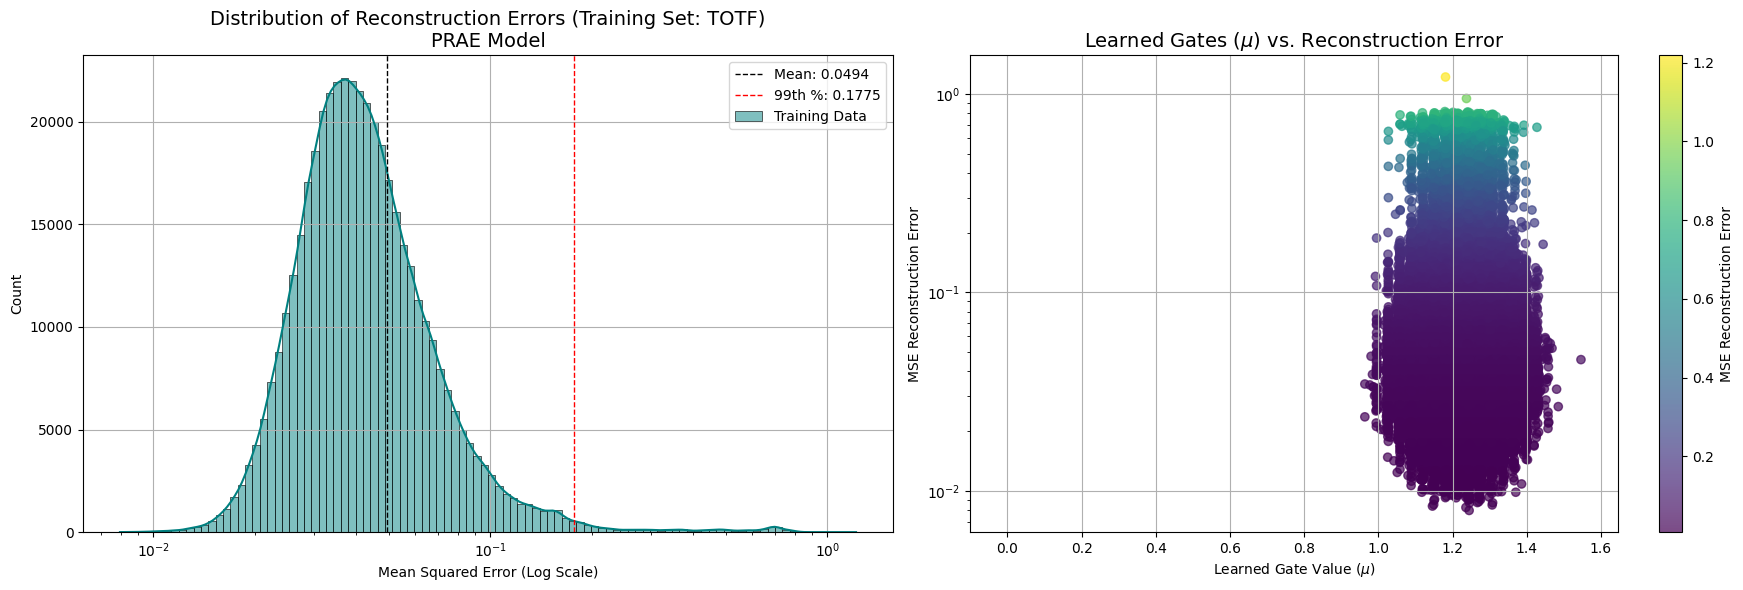

Training Set Statistics:
Mean MSE    : 0.049379
Median MSE  : 0.040391
Std Dev     : 0.044770
Max MSE     : 1.218277


In [6]:
# Reconstruction Error
input_dim = len(setup_pipeline.feature_names)
base_ae = ml.TransformerAutoencoder(
    num_features=input_dim, 
    model_dim=64, 
    num_heads=4, 
    num_layers=2, 
    representation_dim=128, 
    sequence_length=setup_pipeline.seq_length
)
setup_pipeline.model = ml.ProbabilisticRobustAutoencoder(base_ae, num_train_samples=1)
setup_pipeline.model.to(setup_pipeline.device)

if 'mu' in state_dict: del state_dict['mu']
setup_pipeline.model.load_state_dict(state_dict, strict=False)
setup_pipeline.model.eval()

train_loader = setup_pipeline._get_dataloader(setup_pipeline.X_train, shuffle=False)
train_errors = []

with torch.no_grad():
    for batch in train_loader:
        inputs = batch[0].to(setup_pipeline.device)
        
        rec, _ = setup_pipeline.model(inputs, training=False)
        
        # MSE per sequence
        mse = torch.mean((inputs - rec) ** 2, dim=[1, 2])
        train_errors.append(mse.cpu().numpy())

train_errors = np.concatenate(train_errors)

# Plot
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
sns.histplot(train_errors, bins=100, kde=True, color='teal', label='Training Data', log_scale=(True, False))

# Add markers for statistics
mean_err = np.mean(train_errors)
thresh_99 = np.percentile(train_errors, 99)

plt.axvline(mean_err, color='k', linestyle='--', linewidth=1, label=f'Mean: {mean_err:.4f}')
plt.axvline(thresh_99, color='r', linestyle='--', linewidth=1, label=f'99th %: {thresh_99:.4f}')

plt.title(f'Distribution of Reconstruction Errors (Training Set: {DATASET})\nPRAE Model', fontsize=14)
plt.xlabel('Mean Squared Error (Log Scale)')
plt.ylabel('Count')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
sc = plt.scatter(mu, train_errors, c=train_errors, cmap='viridis', alpha=0.7)
plt.colorbar(sc, label='MSE Reconstruction Error')
plt.title('Learned Gates ($\mu$) vs. Reconstruction Error', fontsize=14)
plt.xlabel('Learned Gate Value ($\mu$)')
plt.ylabel('MSE Reconstruction Error')
plt.yscale('log')
plt.xlim(-0.1, max(1.1, np.max(mu) + 0.1))
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Training Set Statistics:")
print(f"Mean MSE    : {mean_err:.6f}")
print(f"Median MSE  : {np.median(train_errors):.6f}")
print(f"Std Dev     : {np.std(train_errors):.6f}")
print(f"Max MSE     : {np.max(train_errors):.6f}")

Running inference for model type: prae...
Inference Complete. Found 97248 anomalies out of 192080 samples.


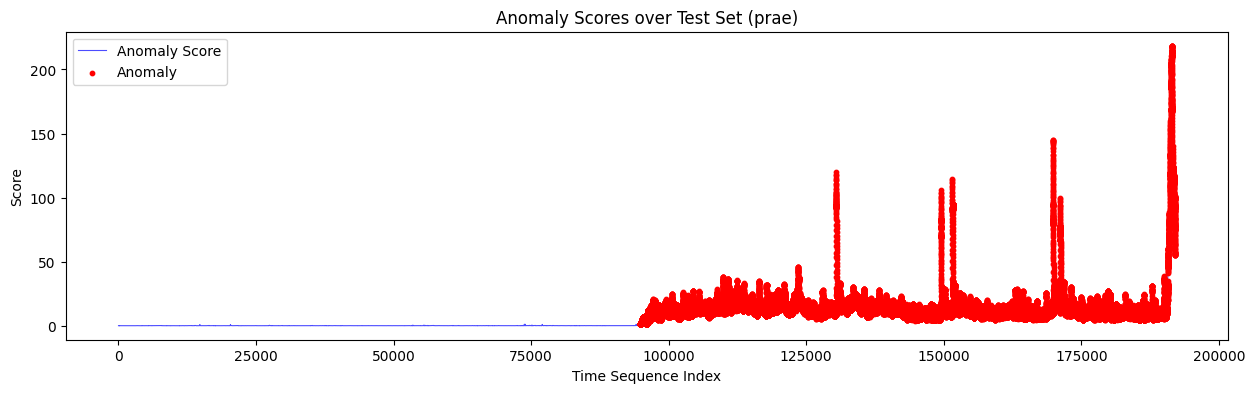

In [7]:
print(f"Running inference for model type: {cfg['model_type']}...")
pipeline.model.eval()

if cfg['model_type'] == 'prae':
    _, scores, preds = pipeline.evaluate_prae(y_true=None)
elif cfg['model_type'] == 'transformer_ocsvm':
    _, scores, preds = pipeline.evaluate_transformer_ocsvm(y_true=None)
elif cfg['model_type'] == 'pnn':
    _, scores, preds = pipeline.evaluate_pnn(y_true=None)

anomaly_indices = np.where(preds == 1)[0]
print(f"Inference Complete. Found {len(anomaly_indices)} anomalies out of {len(scores)} samples.")

# Plot
plt.figure(figsize=(15, 4))
plt.plot(scores, label='Anomaly Score', color='blue', alpha=0.7, linewidth=0.8)
if len(anomaly_indices) > 0:
    plt.scatter(anomaly_indices, scores[anomaly_indices], color='red', s=10, label='Anomaly', zorder=5)
plt.title(f"Anomaly Scores over Test Set ({cfg['model_type']})")
plt.xlabel("Time Sequence Index")
plt.ylabel("Score")
plt.legend()
plt.show()

Analyzing 97248 anomalies for root causes...
Dropped 96040 anomaly indices that were out of bounds for the test set.


C:\Users\adoni\AppData\Local\Temp\ipykernel_26596\385009025.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=root_cause_df.head(15), x='Feature', y='Contribution', palette='mako')


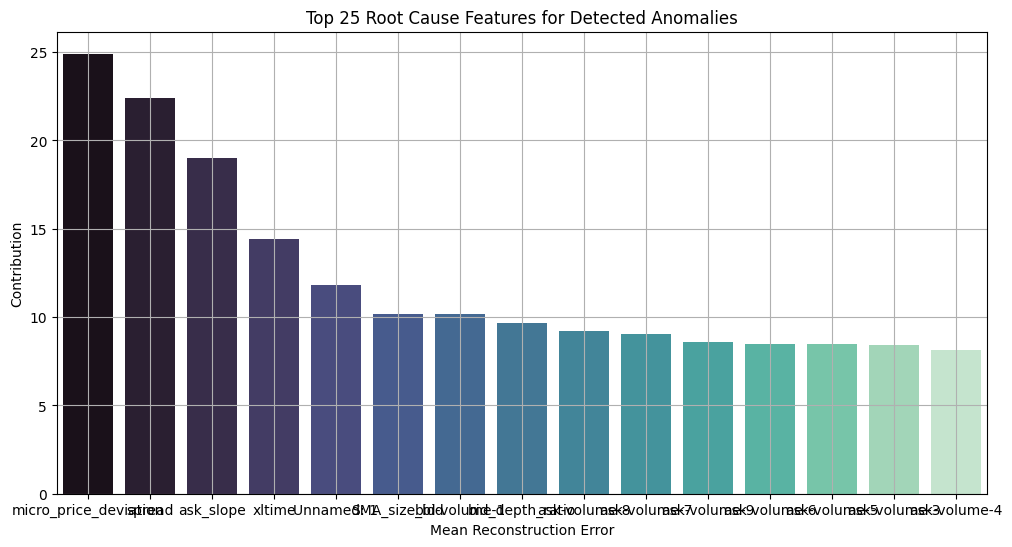

,Feature,Contribution
45,micro_price_deviation,24.918379
42,spread,22.386904
62,ask_slope,18.989809
0,xltime,14.423358
1,Unnamed: 1,11.840814
73,SMA_size_bid,10.168613
3,bid-volume-1,10.143954
46,bid_depth_ratio,9.636580
33,ask-volume-8,9.225045
29,ask-volume-7,9.026695


In [16]:
anomaly_indices = np.where(preds == 1)[0]

if len(anomaly_indices) > 0:
    root_cause_df = ml.analyze_root_causes(pipeline, anomaly_indices, setup_pipeline.feature_names)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=root_cause_df.head(15), x='Feature', y='Contribution', palette='mako')
    plt.title("Top 25 Root Cause Features for Detected Anomalies")
    plt.xlabel('Mean Reconstruction Error')
    plt.grid(True)
    plt.show()

    display(root_cause_df.head(25))
else:
    print("No anomalies detected to analyze for root causes.")